# Create a Landsat Composite

We have 11 input landsat images which provide partional coverage of the study region. A common solution to this problem is to create some form of composite of those images creating a single image which covers the full region.

In this notebook you will look at a number of options for creating a composite.


# 1. Define Imports

In [1]:
import glob
import os

import matplotlib.pyplot as plt
import rsgislib
import rsgislib.tools.filetools

# Import the RSGISLib plotting module which has functions for helping
# to read and visualise image data within a plot for visualisation
# within a notebook.
import rsgislib.tools.plotting

# Use this import is you have rsgislib v5.0.0 to v5.0.7.
# the following import is a local version of the imagecomp file.
from imagecomp import create_max_ndvi_ndwi_composite

# Use this import is you have rsgislib v5.0.0 to v5.0.4.
# the following import is a local version of the imagecomp file.
from plotting import cumulative_stretch_np_arr

# Use this rsgislib import is you have rsgislib v5.0.8 or higher.
# from rsgislib.imageutils.imagecomp import create_max_ndvi_ndwi_composite


# Use this rsgislib import is you have rsgislib v5.0.5 or higher.
# from rsgislib.tools.plotting import cumulative_stretch_np_arr


# Import the matplotlib plotting module and set it to work within
# a notebook environment.
%matplotlib inline

## 1.1 Create output directory

In [2]:
out_dir = "ls_comp_outs"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

# 2. Define the input images

Using glob get a list of all the input images.

In [3]:
input_imgs = glob.glob("../data/is2_bathy/ls_imgs/*.tif")
for i, input_img in enumerate(input_imgs):
    print(f"{i+1}: {input_img}")

1: ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd.tif
2: ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd.tif
3: ../data/is2_bathy/ls_imgs/lc09_l2sp_006038_20220101_20220123_02_t1_sref_sub_mskd.tif
4: ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170807_20200903_02_t1_sref_sub_mskd.tif
5: ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210311_20210317_02_t1_sref_sub_mskd.tif
6: ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170417_20200904_02_t1_sref_sub_mskd.tif
7: ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210802_20210811_02_t1_sref_sub_mskd.tif
8: ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20180522_20200901_02_t1_sref_sub_mskd.tif
9: ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20150122_20200910_02_t1_sref_sub_mskd.tif
10: ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20180623_20200831_02_t1_sref_sub_mskd.tif
11: ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20190829_20200826_02_t1_sref_sub_mskd.tif


# 3. Visualise the Input Images

It is recommend that you open these images in either TuiView or QGIS or similar check out the images in detail. Are there bits of cloud missing or other data issues which you might want to sort out before moving on with the processing. **Note, errors in the input image will affect the quality of the outputs**

Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358


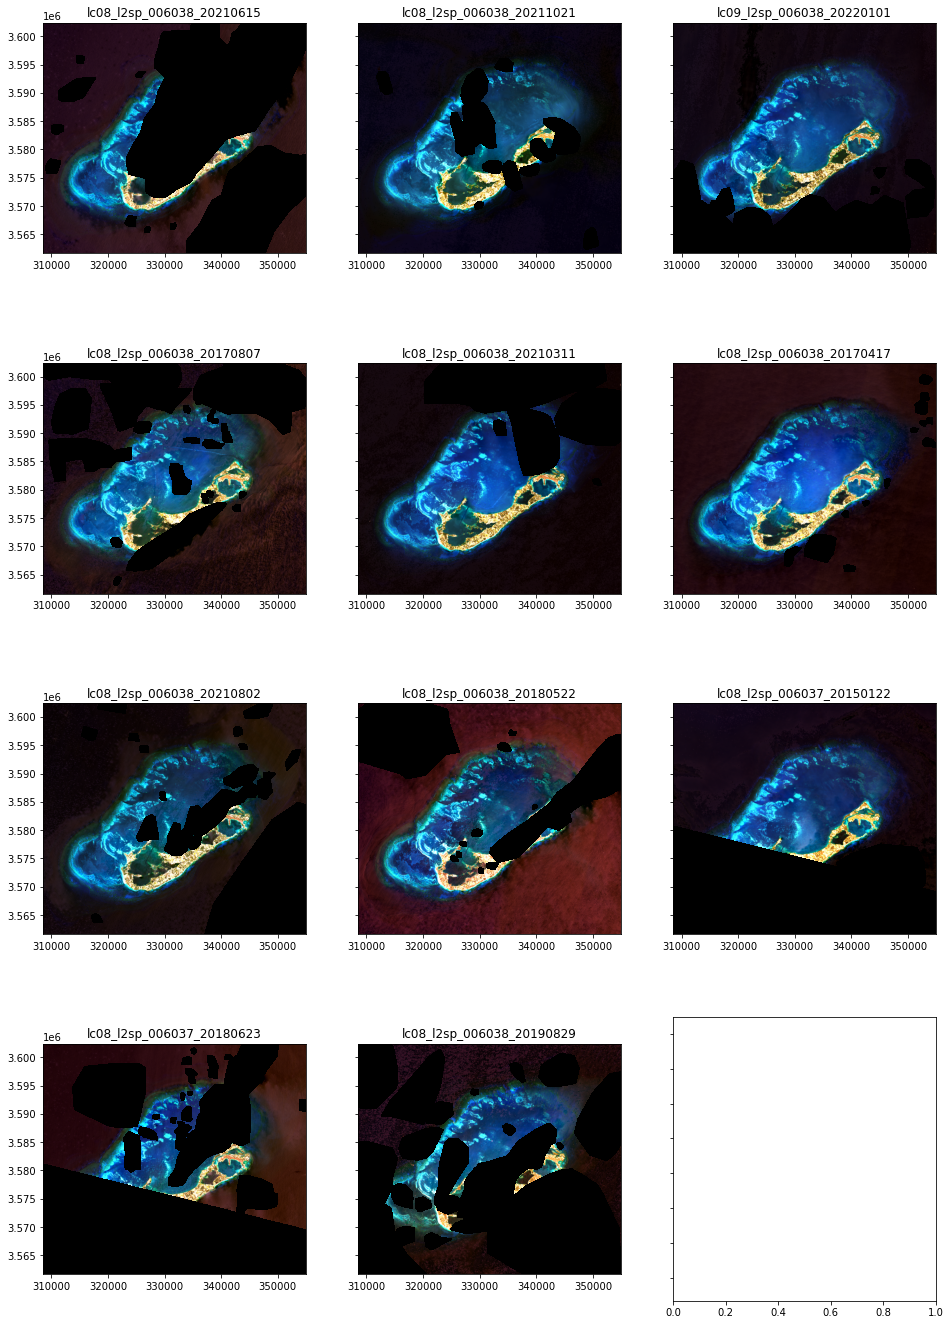

In [4]:
# Create the matplotlib figure - in this case a grid of 2 x 3.
(
    fig,
    ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9), (ax10, ax11, ax12)),
) = plt.subplots(4, 3, figsize=(16, 24), sharey=True)
# Create a list for the 11 axes used for the plot - note we are ignoring ax12 as there are 11 input images.
plot_axes = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11]

for ax, input_img in zip(plot_axes, input_imgs):
    # Get the first part of the file name to use as the plot title
    basename = rsgislib.tools.filetools.get_file_basename(input_img, n_comps=4)
    # Plot RGB bands.
    img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
        input_img, bands=[4, 3, 2]
    )

    # Stretch the image data so is visualises appropriately and usefully
    # In this case the resulting values will be between 0-1.
    img_data_strch = cumulative_stretch_np_arr(img_data, no_data_val=-9999)

    # Add the stretched image data to the plot and define the spatial
    # extent so the axis labels are the coordinates.
    ax.imshow(img_data_strch, extent=img_coords)
    ax.title.set_text(basename)

What can you see looking at all these images? 

 1. They all have bit missing - due to cloud cover.
 2. They all show the same patterns in the water but maybe the constrast between is a little bit different?

# 4. Create a Mean Composite

One of the simplest things to do is to just take the mean pixel value for each band from all the input images, ignoring the no data values. 

However, this means that each band is treated independently which is not ideal. Additionally, means can be easily altered by outlers (e.g., clouds or cloud shadows).

In [5]:
mean_comp_img = os.path.join(out_dir, "bermuda_mean_landsat_comp.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    input_imgs,
    output_img=mean_comp_img,
    summary_stat=rsgislib.SUMTYPE_MEAN,
    gdalformat="KEA",
    datatype=rsgislib.TYPE_32INT,
    no_data_val=-9999,
    use_no_data=True,
)
rsgislib.imageutils.pop_img_stats(
    mean_comp_img, use_no_data=True, no_data_val=-9999, calc_pyramids=True
)

Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc09_l2sp_006038_20220101_20220123_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170807_20200903_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210311_20210317_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170417_20200904_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210802_20210811_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20180522_20200901_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20150122_20200910_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20180623_20200831_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20190829_20200826_0

Image Data Size: 1546 x 1358


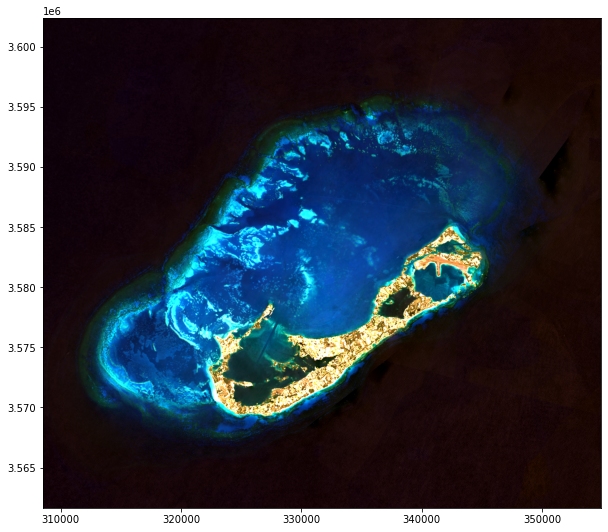

In [6]:
# Get the image data as a true colour (i.e., Red, Green, Blue)
# visualisation using the bands to  [4, 3, 2]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    mean_comp_img, bands=[4, 3, 2]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = cumulative_stretch_np_arr(img_data, no_data_val=-9999)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# 5. Create a Median Composite

A better alternative to a mean composite is to create a median composite which is less sensitive to outlers but each band is still treated independently.


In [7]:
median_comp_img = os.path.join(out_dir, "bermuda_median_landsat_comp.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    input_imgs,
    output_img=median_comp_img,
    summary_stat=rsgislib.SUMTYPE_MEAN,
    gdalformat="KEA",
    datatype=rsgislib.TYPE_32INT,
    no_data_val=-9999,
    use_no_data=True,
)
rsgislib.imageutils.pop_img_stats(
    median_comp_img, use_no_data=True, no_data_val=-9999, calc_pyramids=True
)

Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc09_l2sp_006038_20220101_20220123_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170807_20200903_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210311_20210317_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170417_20200904_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210802_20210811_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20180522_20200901_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20150122_20200910_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20180623_20200831_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20190829_20200826_0

Image Data Size: 1546 x 1358


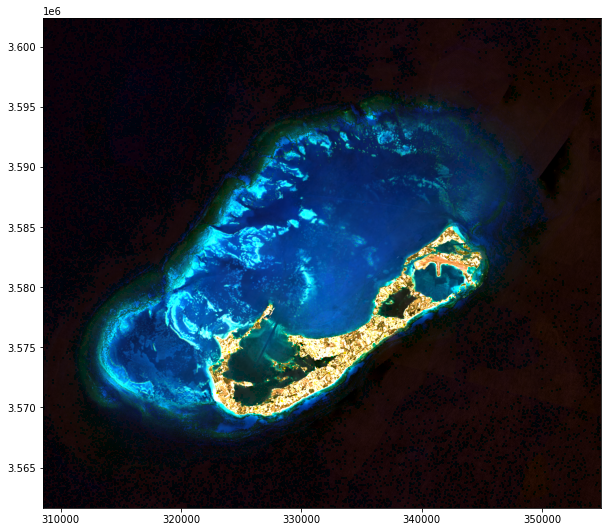

In [8]:
# Get the image data as a true colour (i.e., Red, Green, Blue)
# visualisation using the bands to  [4, 3, 2]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    median_comp_img, bands=[4, 3, 2]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = cumulative_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# 6. Create Minimum or Maximum Composites

Probably not appropriate in this case but just to illustrate you can use the same function to create minimum and maximum reflectance composites.


In [9]:
min_comp_img = os.path.join(out_dir, "bermuda_min_landsat_comp.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    input_imgs,
    output_img=min_comp_img,
    summary_stat=rsgislib.SUMTYPE_MIN,
    gdalformat="KEA",
    datatype=rsgislib.TYPE_32INT,
    no_data_val=-9999,
    use_no_data=True,
)
rsgislib.imageutils.pop_img_stats(
    min_comp_img, use_no_data=True, no_data_val=-9999, calc_pyramids=True
)

Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc09_l2sp_006038_20220101_20220123_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170807_20200903_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210311_20210317_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170417_20200904_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210802_20210811_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20180522_20200901_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20150122_20200910_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20180623_20200831_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20190829_20200826_0

Image Data Size: 1546 x 1358


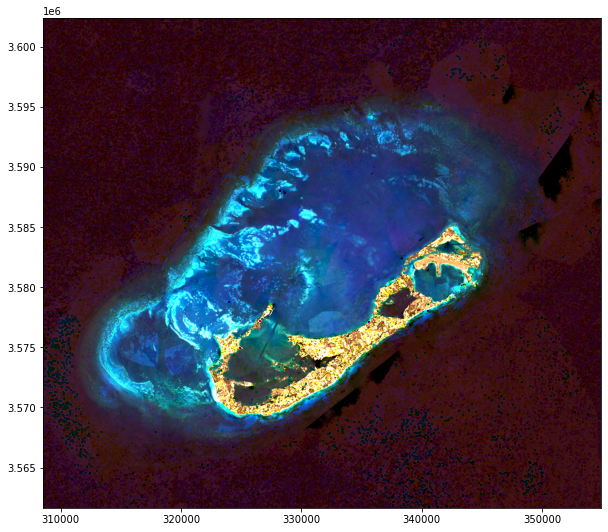

In [10]:
# Get the image data as a true colour (i.e., Red, Green, Blue)
# visualisation using the bands to  [4, 3, 2]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    min_comp_img, bands=[4, 3, 2]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = cumulative_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

In [11]:
max_comp_img = os.path.join(out_dir, "bermuda_max_landsat_comp.kea")
rsgislib.imagecalc.calc_multi_img_band_stats(
    input_imgs,
    output_img=max_comp_img,
    summary_stat=rsgislib.SUMTYPE_MAX,
    gdalformat="KEA",
    datatype=rsgislib.TYPE_32INT,
    no_data_val=-9999,
    use_no_data=True,
)
rsgislib.imageutils.pop_img_stats(
    max_comp_img, use_no_data=True, no_data_val=-9999, calc_pyramids=True
)

Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc09_l2sp_006038_20220101_20220123_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170807_20200903_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210311_20210317_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20170417_20200904_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20210802_20210811_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20180522_20200901_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20150122_20200910_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006037_20180623_20200831_02_t1_sref_sub_mskd.tif
Opening ../data/is2_bathy/ls_imgs/lc08_l2sp_006038_20190829_20200826_0

Image Data Size: 1546 x 1358


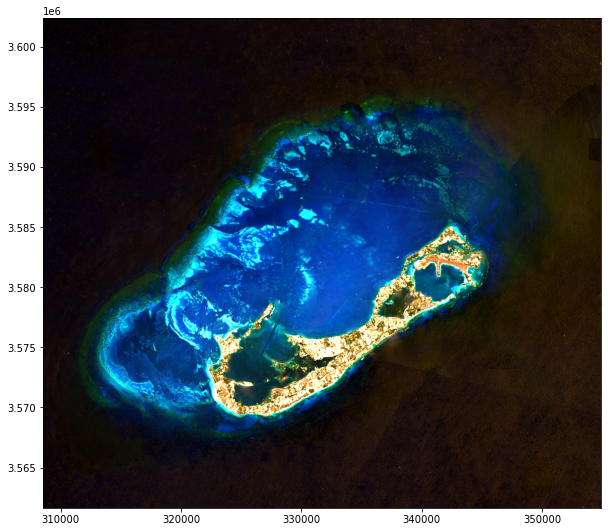

In [12]:
# Get the image data as a true colour (i.e., Red, Green, Blue)
# visualisation using the bands to  [4, 3, 2]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    max_comp_img, bands=[4, 3, 2]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = cumulative_stretch_np_arr(img_data, no_data_val=0.0)

# Create a plot using the matplotlib library
fig, ax = plt.subplots(figsize=(10, 10))

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax.imshow(img_data_strch, extent=img_coords)

# 7. Create a Max. NDVI and NDWI Composite

RSGISLib has a specific compositing function which attempts to create a land/water mask where over the land it produces a maximum NDVI composite while over the water areas it produces a maximum NDWI composite. Once this function has run you will want to check that classification of water verses land as errors in that layer will affect the quality of the resulting composite.

Our images already cover the same extent but if your images covered a number of extents then the reference input image is used to define the output image extent. This can be useful when producing a set of tiles, for example.


This command produces 3 output images:

 1. The output composite image
 2. The mask separating land and water.
 3. A reference image from which you can identify which input image the output pixel value was taken from. 


In [13]:
max_ndvi_ndwi_val_comp_ref_img = os.path.join(
    out_dir, "bermuda_max_ndvi_ndwi_landsat_comp_ref.kea"
)
max_ndvi_ndwi_val_comp_img = os.path.join(
    out_dir, "bermuda_max_ndvi_ndwi_landsat_comp.kea"
)
max_ndvi_ndwi_val_comp_wl_msk = os.path.join(
    out_dir, "bermuda_max_ndvi_ndwi_landsat_water_land_msk.kea"
)

create_max_ndvi_ndwi_composite(
    ref_sp_img=input_imgs[0],
    input_imgs=input_imgs,
    r_band=4,
    n_band=5,
    s_band=6,
    out_ref_img=max_ndvi_ndwi_val_comp_ref_img,
    out_comp_img=max_ndvi_ndwi_val_comp_img,
    out_msk_img=max_ndvi_ndwi_val_comp_wl_msk,
    tmp_path="tmp",
    gdalformat="KEA",
    datatype=None,
    calc_stats=True,
    reproj_method=rsgislib.INTERP_CUBIC,
    use_mode=True,
)

There are 11 images with overlap to create the composite.
Subset images to reference extent.






















In Image (1):	tmp/subset_511171/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd_subset.kea
Image: tmp/subset_511171/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd_subset.kea
	 Variable 'red' is band 4
	 Variable 'nir' is band 5
New image width = 1546 height = 1358 bands = 1

Image: tmp/subset_511171/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd_subset.kea
	 Variable 'swir' is band 6
	 Variable 'nir' is band 5
New image width = 1546 height = 1358 bands = 1

In Image (2):	tmp/subset_511171/lc08_l2sp_006038_20211021_20211103_02_t1_sref_sub_mskd_subset.keaImage: tmp/ref_lyrs_511171/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd_subset_ndvi.kea

	 Variable 'ndvi' is band 1
Image: tmp/ref_lyrs_511171/lc08_l2sp_006038_20210615_20210622_02_t1_sref_sub_mskd_subset_ndwi.kea
	 Variable 'ndwi' is band 1
New image width = 1546 height = 1358 bands = 1

Im

Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358
Image Data Size: 1546 x 1358


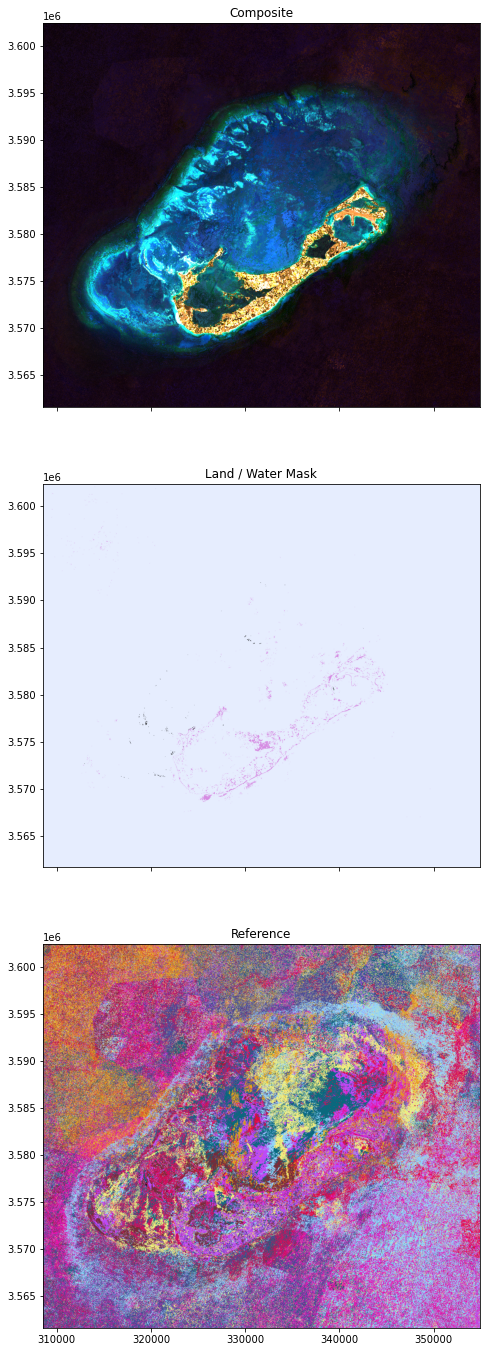

In [14]:
# Create the matplotlib figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 24), sharex=True)

# Get the image data as a true colour (i.e., Red, Green, Blue)
# visualisation using the bands to  [4, 3, 2]
img_data, img_coords = rsgislib.tools.plotting.get_gdal_raster_mpl_imshow(
    max_ndvi_ndwi_val_comp_img, bands=[4, 3, 2]
)

# Stretch the image data so is visualises appropriately and usefully
# In this case the resulting values will be between 0-1.
img_data_strch = cumulative_stretch_np_arr(img_data, no_data_val=-9999)

# Add the stretched image data to the plot and define the spatial
# extent so the axis labels are the coordinates.
ax1.imshow(img_data_strch, extent=img_coords)
ax1.title.set_text("Composite")


(
    img_data_arr,
    coords_bbox,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    max_ndvi_ndwi_val_comp_wl_msk
)

ax2.imshow(img_data_arr, extent=img_coords)
ax2.title.set_text("Land / Water Mask")


(
    img_data_arr,
    coords_bbox,
    lgd_patches,
) = rsgislib.tools.plotting.get_gdal_thematic_raster_mpl_imshow(
    max_ndvi_ndwi_val_comp_ref_img
)

ax3.imshow(img_data_arr, extent=img_coords)
ax3.title.set_text("Reference")

# 8. Conclusions

In this case the input imagery is pretty tidy so it looks like all the methods have all provided quite a good output. However, the minimum and maximum composites have some clear artifacts so those should be rejected in preference of one of the others. It it suggested that you would probably want to open these composites in TuiView or QGIS and compare them in more detail. 

For the next notebook will will use the maximum ndvi/ndwvi composite as that treats image pixels as single units rather than bands separately and will therefore have pixel values which are measured reflectances rather than derived (i.e., mean or median).
